[itsandrewgao](https://twitter.com/itsandrewgao) my very rushed and shitty attempt at implementing just the mLSTM to predict sine waves

<a target="_blank" href="https://colab.research.google.com/github/andrewgcodes/xlstm/blob/main/mLSTM.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt

def generate_sine_wave(seq_len, num_sequences):
    x = np.linspace(0, 2 * np.pi, seq_len)
    y = np.sin(x)
    return torch.tensor(y).float().view(-1, 1).repeat(1, num_sequences).unsqueeze(0)

class mLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, mem_dim):
        super(mLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.mem_dim = mem_dim
        self.Wq = nn.Parameter(torch.randn(hidden_size, input_size))
        self.bq = nn.Parameter(torch.randn(hidden_size, 1))
        self.Wk = nn.Parameter(torch.randn(mem_dim, input_size))
        self.bk = nn.Parameter(torch.randn(mem_dim, 1))
        self.Wv = nn.Parameter(torch.randn(mem_dim, input_size))
        self.bv = nn.Parameter(torch.randn(mem_dim, 1))
        self.wi = nn.Parameter(torch.randn(1, input_size))
        self.bi = nn.Parameter(torch.randn(1))
        self.wf = nn.Parameter(torch.randn(1, input_size))
        self.bf = nn.Parameter(torch.randn(1))
        self.Wo = nn.Parameter(torch.randn(hidden_size, input_size))
        self.bo = nn.Parameter(torch.randn(hidden_size, 1))
        self.reset_parameters()

    def reset_parameters(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def forward(self, x, states):
        (C_prev, n_prev) = states
        qt = torch.matmul(self.Wq, x) + self.bq
        kt = (1 / math.sqrt(self.mem_dim)) * (torch.matmul(self.Wk, x) + self.bk)
        vt = torch.matmul(self.Wv, x) + self.bv

        it = torch.exp(torch.matmul(self.wi, x) + self.bi)
        ft = torch.sigmoid(torch.matmul(self.wf, x) + self.bf)

        vt = vt.squeeze()
        kt = kt.squeeze()

        C = ft * C_prev + it * torch.ger(vt, kt)
        n = ft * n_prev + it * kt.unsqueeze(1)

        max_nqt = torch.max(torch.abs(torch.matmul(n.T, qt)), torch.tensor(1.0))
        h_tilde = torch.matmul(C, qt) / max_nqt
        ot = torch.sigmoid(torch.matmul(self.Wo, x) + self.bo)
        ht = ot * h_tilde

        return ht, (C, n)

    def init_hidden(self):
        return (torch.zeros(self.mem_dim, self.mem_dim),
                torch.zeros(self.mem_dim, 1))




In [5]:
input_size = 1
hidden_size = 10
mem_dim = 10
seq_len = 100
num_sequences = 1

model = mLSTM(input_size, hidden_size, mem_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

data = generate_sine_wave(seq_len, num_sequences)
print("data",data.shape)
states = model.init_hidden()

for epoch in range(300):
    
    optimizer.zero_grad()
    loss = 0
    for t in range(seq_len - 1):
        x = data[:, t]
        y_true = data[:, t + 1]
        y_pred, states = model(x, states)

        loss += criterion(y_pred, y_true)

    states = (states[0].detach(), states[1].detach())
    
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch} Loss {loss.item()}')

test_output = []
states = model.init_hidden()
for t in range(seq_len - 1):
    x = data[:, t]
    y_pred, states = model(x, states)
    test_output.append(y_pred.detach().numpy().ravel()[0])



data torch.Size([1, 100, 1])
Epoch 0 Loss 57.310420989990234
Epoch 100 Loss 7.102836608886719
Epoch 200 Loss 0.4399712383747101


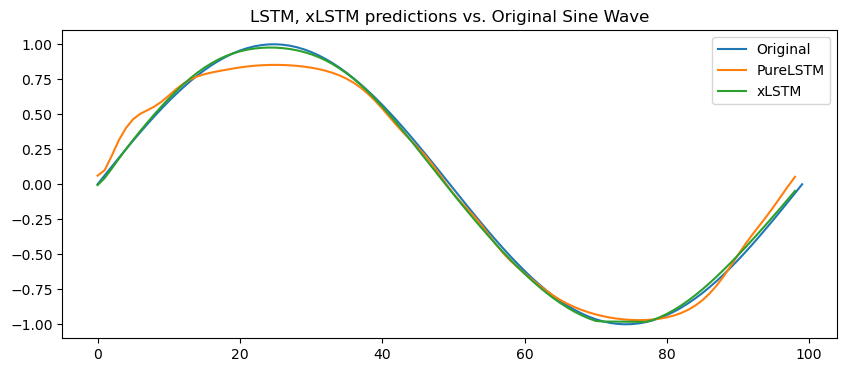

In [10]:
with open('lstm_results.npy', 'rb') as f:
    loaded_lstm_output = np.load(f)
    
test_output = []
states = model.init_hidden()
for t in range(seq_len - 1):
    x = data[:, t]
    y_pred, states = model(x, states)
    test_output.append(y_pred.detach().numpy().ravel()[0])

plt.figure(figsize=(10, 4))
plt.title('LSTM, xLSTM predictions vs. Original Sine Wave')
plt.plot(data.numpy().ravel(), label='Original')
plt.plot(loaded_lstm_output, label='PureLSTM')
plt.plot(test_output, label='xLSTM')
plt.legend()
plt.show()